# Figure 3 notebook - this focuses on severe

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# setup all the imports
import matplotlib.font_manager
import matplotlib.pyplot as plt
import cartopy.crs as ccrs  # noqa: E402
import numpy as np
import seaborn as sns
import pandas as pd

flist = matplotlib.font_manager.get_font_names()
from pathlib import Path  # noqa: E402

from extremeweatherbench import evaluate, calc, cases, defaults, inputs, metrics, regions, derived, utils

# make the basepath - change this to your local path
basepath = Path.home() / "extreme-weather-bench-paper" / ""
basepath = str(basepath) + "/"

# ugly hack to load in our plotting scripts
# import sys  # noqa: E402

#sys.path.append(basepath + "/docs/notebooks/")
import src.plots.plotting_utils as plot_utils  # noqa: E402
import src.plots.results_utils as results_utils  # noqa: E402
import src.plots.severe_convection_utils as severe_utils


In [3]:

# load in all of the events in the yaml file
print("loading in the events yaml file")
ewb_cases = cases.load_ewb_events_yaml_into_case_collection()

# downselect to only the severe cases
ewb_cases = ewb_cases.select_cases("event_type", "severe_convection")

# build out all of the expected data to evalate the case (we need this so we can plot
# the LSR reports)
case_operators = cases.build_case_operators(
    ewb_cases, defaults.get_brightband_evaluation_objects()
)


loading in the events yaml file


In [4]:
# to plot the targets, we need to run the pipeline for each case and target
from joblib import Parallel, delayed  # noqa: E402
from joblib.externals.loky import get_reusable_executor  # noqa: E402

# load in all the case info (note this takes awhile in non-parallel form as it has to
# run all the target information for each case)
# this will return a list of tuples with the case id and the target dataset

print("running the pipeline for each case and target")
parallel = Parallel(n_jobs=32, return_as="generator", backend="loky")
case_operators_with_targets_established_generator = parallel(
    delayed(
        lambda co: (
            co.case_metadata.case_id_number,
            evaluate.run_pipeline(co.case_metadata, co.target),
        )
    )(case_operator)
    for case_operator in case_operators
)
case_operators_with_targets_established = list(
    case_operators_with_targets_established_generator
)
# this will throw a bunch of errors below but they're not consequential. this releases
# the memory as it shuts down the workers
get_reusable_executor().shutdown(wait=True)


running the pipeline for each case and target


In [5]:
# make a global color palatte so things are consistent across plots
sns_palette = sns.color_palette("tab10")
sns.set_style("whitegrid")

accessible_colors = [
    "#3394D6",  # blue
    "#E09000",  #  orange "#E69F00",  # orange
    "#A15A7E",  # "#CC79A7",  # reddish purple
    "#CC4A4A",  #  vermillion"#D55E00",  # vermillion
    "#A0A0A0",  # Grey "#000000",  # black
    "#B2B24D",  # Olive
    "#33B890",  # bluish green
    "#78C6F1",  # sky blue
    "#F0E442",  # yellow
]

# defaults for plotting
fourv2_style = {'color': accessible_colors[0]}
gc_style = {'color': accessible_colors[2]}
pangu_style = {'color': accessible_colors[3]}
hres_style = {'color': 'black'}

# the group styles and settings so that we can just easily grab them for the plots and they are globally consistent

ghcn_group_style = {'linestyle':'-', 'marker':'o', 'group':'GHCN'}
era5_group_style = {'linestyle':'--', 'marker':'s', 'group':'ERA5'}

ifs_group_style = {'linestyle':'-', 'marker':'o', 'group':'IFS'}
gfs_group_style = {'linestyle':':', 'marker':'d', 'group':'GFS'}

global_group_style = {'linestyle':'--', 'marker':'*', 'group':'Global'}

hres_group_style = {'linestyle':'-', 'marker':'.', 'group':'HRES'}

# settings for the different models
fourv2_ifs_cira_settings = {'forecast_source':'CIRA FOURv2 IFS', 'label_str': 'ForecastNet V2'} 
fourv2_gfs_cira_settings = {'forecast_source':'CIRA FOURv2 GFS', 'label_str': 'ForecastNet V2'} 
gc_ifs_cira_settings = {'forecast_source':'CIRA GC IFS', 'label_str': 'GraphCast'} 
gc_gfs_cira_settings = {'forecast_source':'CIRA GC GFS', 'label_str': 'GraphCast'} 
pangu_ifs_cira_settings = {'forecast_source':'CIRA PANG IFS', 'label_str': 'Pangu Weather'} 
pangu_gfs_cira_settings = {'forecast_source':'CIRA PANG GFS', 'label_str': 'Pangu Weather'} 

hres_ifs_settings = {'forecast_source':'ECMWF HRES', 'label_str': 'HRES'} 

fourv2_ifs_settings = fourv2_ifs_cira_settings | fourv2_style | ifs_group_style
gc_ifs_settings = gc_ifs_cira_settings | gc_style | ifs_group_style
pangu_ifs_settings = pangu_ifs_cira_settings | pangu_style | ifs_group_style
hres_settings = hres_ifs_settings | hres_style | hres_group_style

fourv2_gfs_settings = fourv2_gfs_cira_settings | fourv2_style | gfs_group_style
gc_gfs_settings = gc_gfs_cira_settings | gc_style | gfs_group_style
pangu_gfs_settings = pangu_gfs_cira_settings | pangu_style | gfs_group_style

severe_tp_settings = {'linestyle':'-', 'marker':'o', 'group':'True Positives'}
severe_fn_settings = {'linestyle':'--', 'marker':'x', 'group':'False Negatives'}


In [6]:
# load the results back in
fourv2_severe_results = pd.read_pickle(basepath + 'saved_data/fourv2_severe_results.pkl')
pang_severe_results = pd.read_pickle(basepath + 'saved_data/pang_severe_results.pkl')
hres_severe_results = pd.read_pickle(basepath + 'saved_data/hres_severe_results.pkl')
gc_severe_results = pd.read_pickle(basepath + 'saved_data/gc_severe_results.pkl')


In [7]:
fourv2_gfs_era5_settings_tp = fourv2_gfs_cira_settings | fourv2_style | severe_tp_settings 
gc_gfs_era5_settings_tp  = gc_gfs_cira_settings | gc_style | severe_tp_settings 
pangu_gfs_era5_settings_tp = pangu_gfs_cira_settings | pangu_style | severe_tp_settings 
hres_era5_settings_tp = hres_ifs_settings | hres_style | severe_tp_settings 

# grab the severe results
fourv2_severe_plot_tp = results_utils.subset_results_to_xarray(results_df=fourv2_severe_results, 
    forecast_source=fourv2_gfs_cira_settings['forecast_source'], 
    target_source='local_storm_reports', metric='TruePositives', init_time='zeroz')
gc_severe_plot_tp = results_utils.subset_results_to_xarray(results_df=gc_severe_results, 
    forecast_source=gc_gfs_cira_settings['forecast_source'], 
    target_source='local_storm_reports', metric='TruePositives', init_time='zeroz')
pangu_severe_plot_tp  = results_utils.subset_results_to_xarray(results_df=pang_severe_results, 
    forecast_source=pangu_gfs_cira_settings['forecast_source'], 
    target_source='local_storm_reports', metric='TruePositives', init_time='zeroz')
hres_severe_plot_tp = results_utils.subset_results_to_xarray(results_df=hres_severe_results, 
    forecast_source=hres_ifs_settings['forecast_source'], 
    target_source='local_storm_reports', metric='TruePositives', init_time='zeroz')

# plot the results
severe_data_tp = [gc_severe_plot_tp, pangu_severe_plot_tp, hres_severe_plot_tp, fourv2_severe_plot_tp]
severe_settings_tp = [gc_gfs_era5_settings_tp, 
    pangu_gfs_era5_settings_tp, hres_era5_settings_tp, fourv2_gfs_era5_settings_tp]


fourv2_gfs_era5_settings_fn = fourv2_gfs_cira_settings | fourv2_style | severe_fn_settings 
gc_gfs_era5_settings_fn  = gc_gfs_cira_settings | gc_style | severe_fn_settings 
pangu_gfs_era5_settings_fn = pangu_gfs_cira_settings | pangu_style | severe_fn_settings 
hres_era5_settings_fn = hres_ifs_settings | hres_style | severe_fn_settings 
print(gc_gfs_era5_settings_fn)

# grab the results for the false negatives
fourv2_severe_plot_fn = results_utils.subset_results_to_xarray(results_df=fourv2_severe_results, 
    forecast_source=fourv2_gfs_cira_settings['forecast_source'], 
    target_source='local_storm_reports', metric='FalseNegatives', init_time='zeroz')
gc_severe_plot_fn = results_utils.subset_results_to_xarray(results_df=gc_severe_results, 
    forecast_source=gc_gfs_cira_settings['forecast_source'], 
    target_source='local_storm_reports', metric='FalseNegatives', init_time='zeroz')
pangu_severe_plot_fn = results_utils.subset_results_to_xarray(results_df=pang_severe_results, 
    forecast_source=pangu_gfs_cira_settings['forecast_source'], 
    target_source='local_storm_reports', metric='FalseNegatives', init_time='zeroz')
hres_severe_plot_fn = results_utils.subset_results_to_xarray(results_df=hres_severe_results, 
    forecast_source=hres_ifs_settings['forecast_source'], 
    target_source='local_storm_reports', metric='FalseNegatives', init_time='zeroz')

# plot the results
severe_data_fn = [gc_severe_plot_fn, pangu_severe_plot_fn, hres_severe_plot_fn, fourv2_severe_plot_fn]
severe_settings_fn = [gc_gfs_era5_settings_fn, 
    pangu_gfs_era5_settings_fn, hres_era5_settings_fn, fourv2_gfs_era5_settings_fn]

{'forecast_source': 'CIRA GC GFS', 'label_str': 'GraphCast', 'color': '#A15A7E', 'linestyle': '--', 'marker': 'x', 'group': 'False Negatives'}


In [8]:
# make the bounding boxes for the regions

# North America
na_bounding_box = [-172, -45, 7, 85]
na_bounding_box_polygon = plot_utils.get_polygon_from_bounding_box(na_bounding_box)
na_bounding_region = regions.BoundingBoxRegion(latitude_min=7, latitude_max=85, longitude_min=-172, longitude_max=-45)

# australia bounding box
au_bounding_box = [110, 180, -50, -10]
au_bounding_box_polygon = plot_utils.get_polygon_from_bounding_box(au_bounding_box)
au_bounding_region = regions.BoundingBoxRegion(latitude_min=-50, latitude_max=-10, longitude_min=110, longitude_max=180)

# break the cases into different lists
na_subset = regions.RegionSubsetter(region=na_bounding_region, method='intersects').subset_case_collection(ewb_cases)
au_subset = regions.RegionSubsetter(region=au_bounding_region, method='intersects').subset_case_collection(ewb_cases)

na_case_ids = [n.case_id_number for n in na_subset.cases]
au_case_ids = [n.case_id_number for n in au_subset.cases]

print(f'North America Cases: {na_case_ids}')
print(f'Australia Cases: {au_case_ids}')


North America Cases: [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337]
Australia Cases: [257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279]


In [9]:
def get_error_array_for_heatmap(results_array, hres_results, forecast_sources, 
    target_source, metric_strs, init_time, lead_time_days, higher_is_better_list):
    """
    This function takes in an array of results and parameters to say which results to grab and returns 
    error arrays and relative arrays for global, north america, and europe.
    """
    # now make the array for the scorecard
    global_rel_error = {}
    global_error = {}

    na_rel_error = {}
    na_error = {}

    au_rel_error = {}
    au_error = {}


    for i, metric in enumerate(metric_strs):
        # initialize the arrays
        global_rel_error[metric] = np.zeros((len(results_array), len(lead_time_days)))
        global_error[metric] = np.zeros((len(results_array), len(lead_time_days)))

        na_rel_error[metric] = np.zeros((len(results_array), len(lead_time_days)))
        na_error[metric] = np.zeros((len(results_array), len(lead_time_days)))

        au_rel_error[metric] = np.zeros((len(results_array), len(lead_time_days)))
        au_error[metric] = np.zeros((len(results_array), len(lead_time_days)))

        higher_is_better = higher_is_better_list[i]

        for j, results_df in enumerate(results_array):
            my_mean, my_relative_error = results_utils.compute_relative_error(results_df, 
                forecast_source=forecast_sources[j], 
                comparison_results_df=hres_results, 
                comparison_forecast_source=hres_settings['forecast_source'], 
                target_source=target_source, 
                metric=metric, init_time=init_time, lead_time_days=lead_time_days, 
                higher_is_better=higher_is_better)
            global_error[metric][j, :] = my_mean
            global_rel_error[metric][j, :] = my_relative_error

            na_mean, na_relative_error = results_utils.compute_relative_error(results_df,
                forecast_source=forecast_sources[j], 
                comparison_results_df=hres_results, 
                comparison_forecast_source=hres_settings['forecast_source'], 
                target_source=target_source, 
                metric=metric, init_time=init_time, lead_time_days=lead_time_days, 
                case_ids=na_case_ids, 
                higher_is_better=higher_is_better)
            na_error[metric][j, :] = na_mean
            na_rel_error[metric][j, :] = na_relative_error

            au_mean, au_relative_error = results_utils.compute_relative_error(results_df,
                forecast_source=forecast_sources[j], 
                comparison_results_df=hres_results, 
                comparison_forecast_source=hres_settings['forecast_source'], 
                target_source=target_source, 
                metric=metric, init_time=init_time, lead_time_days=lead_time_days, 
                case_ids=au_case_ids, 
                higher_is_better=higher_is_better)
            au_error[metric][j, :] = au_mean
            au_rel_error[metric][j, :] = au_relative_error


    return global_error, global_rel_error, na_error, na_rel_error, au_error, au_rel_error

# setup for the scorecard
# Grab means for each metric for each model
severe_metric_str = ['CriticalSuccessIndex', 'FalseAlarmRatio', 'EarlySignal']
severe_display_str = ['Critical Success Index', 'False Alarm Ratio', 'Early Signal']
severe_metric_higher_is_better = [True, False, True]
target_source = 'practically_perfect_hindcast'

lead_time_days = [1, 3, 5, 7, 10]

severe_results_array = [hres_severe_results, gc_severe_results, 
    pang_severe_results, fourv2_severe_results]
forecast_source = [hres_ifs_settings['forecast_source'], 
    gc_gfs_cira_settings['forecast_source'], 
    pangu_gfs_cira_settings['forecast_source'],
    fourv2_gfs_cira_settings['forecast_source']]


severe_results_array = [hres_severe_results, fourv2_severe_results, gc_severe_results, pang_severe_results]
forecast_source = [hres_ifs_settings['forecast_source'], 
    fourv2_gfs_settings['forecast_source'], 
    gc_gfs_settings['forecast_source'], pangu_gfs_settings['forecast_source']]

(global_severe_error, global_rel_severe_error, na_severe_error, na_rel_severe_error, au_severe_error, au_rel_severe_error) = \
    get_error_array_for_heatmap(severe_results_array, hres_severe_results, 
    forecast_source, 'practically_perfect_hindcast', severe_metric_str, 'zeroz', lead_time_days, severe_metric_higher_is_better )


In [10]:
def get_cbss_and_pph_outputs(ewb_case, forecast_source):
    pph_target = inputs.PPH()
    pph = evaluate.run_pipeline(ewb_case,pph_target)
    cbss = evaluate.run_pipeline(ewb_case,forecast_source)

    return cbss, pph

def get_pph_outputs(ewb_case, forecast_source):
    pph_target = inputs.PPH()
    pph = evaluate.run_pipeline(ewb_case,pph_target)
    return pph


In [ ]:
my_ids = [269, 270, 271, 284, 285, 286, 287, 288, 316, 317, 318, 319, 320, 321, 322, 323]
import pickle
hres_graphics = pickle.load(open(basepath + "saved_data/hres_graphics.pkl", "rb"))
gc_graphics = pickle.load(open(basepath + "saved_data/gc_graphics.pkl", "rb"))
pang_graphics = pickle.load(open(basepath + "saved_data/pang_graphics.pkl", "rb"))
fourv2_graphics = pickle.load(open(basepath + "saved_data/fourv2_graphics.pkl", "rb"))
for my_id in my_ids:
    # compute CBSS and PPH for all the AI models and HRES for the case we chose
    print(my_id)
    my_case = ewb_cases.select_cases("case_id_number", my_id).cases[0]

    # [cbss_hres, pph_hres] = get_cbss_and_pph_outputs(my_case, hres_severe_forecast)
    # [cbss_gc, pph_gc] = get_cbss_and_pph_outputs(my_case, cira_severe_convection_forecast_GC_GFS)
    # [cbss_pang, pph_pang] = get_cbss_and_pph_outputs(my_case, cira_severe_convection_forecast_PANG_GFS)
    # [cbss_fourv2, pph_fourv2] = get_cbss_and_pph_outputs(my_case, cira_severe_convection_forecast_FOURV2_GFS)
    pph_hres = get_pph_outputs(my_case, hres_severe_forecast)
    pph_gc = get_pph_outputs(my_case, cira_severe_convection_forecast_GC_GFS)
    pph_pang = get_pph_outputs(my_case, cira_severe_convection_forecast_PANG_GFS)
    pph_fourv2 = get_pph_outputs(my_case, cira_severe_convection_forecast_FOURV2_GFS)

    hres_graphics[my_id, "pph"] = pph_hres
    gc_graphics[my_id, "pph"] = pph_gc
    pang_graphics[my_id, "pph"] = pph_pang
    fourv2_graphics[my_id, "pph"] = pph_fourv2


In [11]:
import pickle
hres_graphics = pickle.load(open(basepath + "saved_data/hres_graphics.pkl", "rb"))
gc_graphics = pickle.load(open(basepath + "saved_data/gc_graphics.pkl", "rb"))
pang_graphics = pickle.load(open(basepath + "saved_data/pang_graphics.pkl", "rb"))
fourv2_graphics = pickle.load(open(basepath + "saved_data/fourv2_graphics.pkl", "rb"))


In [12]:
def get_lsr_from_case_op(my_case, case_operators_with_targets_established):
    for (id, case_info) in case_operators_with_targets_established:
        if id == my_case.case_id_number:
            if case_info.attrs["source"] == "local_storm_reports":
                return case_info
   
def plot_cbss_pph_panel(cbss, pph, my_case, lsrs, ax=None, title=None, lead_time_hours=0, gridlines_kwargs={}, geographic_features_kwargs={}):
    my_bbox = dict()
    my_bbox["latitude_min"] = my_case.location.latitude_min
    my_bbox["latitude_max"] = my_case.location.latitude_max
    my_bbox["longitude_min"] = my_case.location.longitude_min
    my_bbox["longitude_max"] = my_case.location.longitude_max

    # grab the valid time to plot
    valid_time = cbss.craven_brooks_significant_severe.valid_time
    my_pph = pph.sel(valid_time=valid_time).practically_perfect_hindcast.squeeze()

    # grab the lsrs and convert to a dataframe
    lsrs = lsrs.sel(valid_time=valid_time)
    non_sparse_lsrs = utils.stack_dataarray_from_dims(
                        lsrs["report_type"], ["latitude", "longitude"]
                    ).squeeze()
    hail_data = non_sparse_lsrs[non_sparse_lsrs == 2]
    tornado_data = non_sparse_lsrs[non_sparse_lsrs == 3]
    hail_data = hail_data.to_dataframe().reset_index()
    tornado_data = tornado_data.to_dataframe().reset_index()

    ax, mappable = severe_utils.plot_cbss_forecast_panel(
        cbss_data=cbss.craven_brooks_significant_severe.squeeze(),
        target_date=my_case.start_date,
        lead_time_hours=lead_time_hours,
        bbox=my_bbox,
        ax=ax,
        pph_data=my_pph,
        tornado_reports=tornado_data,
        hail_reports=hail_data,
        title=title,
        alpha=0.6,
        gridlines_kwargs=gridlines_kwargs,
        geographic_features_kwargs=geographic_features_kwargs,
    )
    return ax, mappable

def get_stats(results, forecast_source, my_case, lead_time_hours=0):
    # list the statistics for each case
    tp_all = results_utils.subset_results_to_xarray(results_df=results, 
        forecast_source=forecast_source, 
        target_source='local_storm_reports', metric='TruePositives', 
        init_time='zeroz', case_id_list=[my_case.case_id_number])

    tp_mean = tp_all["value"].mean("case_id_number")
    lead_time_td = pd.Timedelta(hours=lead_time_hours)
    tp = tp_mean.sel(lead_time=lead_time_td, method="nearest")

    fn_all = results_utils.subset_results_to_xarray(results_df=results, 
        forecast_source=forecast_source, 
        target_source='local_storm_reports', metric='FalseNegatives', 
        init_time='zeroz', case_id_list=[my_case.case_id_number])

    fn_mean = fn_all["value"].mean("case_id_number")
    fn = fn_mean.sel(lead_time=lead_time_td, method="nearest")
    
    csi_all = results_utils.subset_results_to_xarray(results_df=results, 
        forecast_source=forecast_source, 
        target_source='practically_perfect_hindcast', metric='CriticalSuccessIndex', 
        init_time='zeroz', case_id_list=[my_case.case_id_number])

    csi_mean = csi_all["value"].mean("case_id_number")
    csi = csi_mean.sel(lead_time=lead_time_td, method="nearest")

    far_all = results_utils.subset_results_to_xarray(results_df=results, 
        forecast_source=forecast_source, 
        target_source='practically_perfect_hindcast', metric='FalseAlarmRatio', 
        init_time='zeroz', case_id_list=[my_case.case_id_number])

    far_mean = far_all["value"].mean("case_id_number")
    far = far_mean.sel(lead_time=lead_time_td, method="nearest")

    es_all = results_utils.subset_results_to_xarray(results_df=results, 
        forecast_source=forecast_source, 
        target_source='practically_perfect_hindcast', metric='EarlySignal', 
        init_time='zeroz', case_id_list=[my_case.case_id_number])

    es_mean = es_all["value"].mean("case_id_number")
    es = es_mean.sel(lead_time=lead_time_td, method="nearest")
    
    return [tp.values, fn.values, csi.values, far.values, es.values]

In [ ]:
my_ids = [269, 270, 271, 284, 285, 286, 287, 288, 316, 317, 318, 319, 320, 321, 322, 323]
my_ids = [269, 318]

# plot all of the cases where we had all three models
for my_id in my_ids:
    print(my_id)
    my_case = ewb_cases.select_cases("case_id_number", my_id).cases[0]
    my_lsr = get_lsr_from_case_op(my_case, case_operators_with_targets_established)
    
    cbss_hres, pph_hres = hres_graphics[my_id, "cbss"], hres_graphics[my_id, "pph"]
    cbss_gc, pph_gc = gc_graphics[my_id, "cbss"], gc_graphics[my_id, "pph"]
    cbss_pang, pph_pang = pang_graphics[my_id, "cbss"], pang_graphics[my_id, "pph"]
    cbss_fourv2, pph_fourv2 = fourv2_graphics[my_id, "cbss"], fourv2_graphics[my_id, "pph"]

    # make a subplot for each model and ensure it is a cartopy plot
    fig, axs = plt.subplots(2, 4, figsize=(10, 4), subplot_kw={'projection': ccrs.PlateCarree()})

    plot_cbss_pph_panel(cbss_hres, pph_hres, my_case, lsrs=my_lsr, ax=axs[0,0], title="HRES", lead_time_hours=48)
    plot_cbss_pph_panel(cbss_gc, pph_gc, my_case, lsrs=my_lsr, ax=axs[0,1], title="GraphCast", lead_time_hours=48)
    plot_cbss_pph_panel(cbss_pang, pph_pang, my_case, lsrs=my_lsr, ax=axs[0,2], title="Pangu", lead_time_hours=48)
    plot_cbss_pph_panel(cbss_fourv2, pph_fourv2, my_case, lsrs=my_lsr, ax=axs[0,3], title="FOURv2", lead_time_hours=48)


    # now plot the stats
    [tp, fn, csi, far, es] = get_stats(hres_severe_results, 
        hres_ifs_settings['forecast_source'], my_case, lead_time_hours=48)

    axs[1,0].text(0.5, 0.5, f"CSI: {csi:.2f}\n"
            f"FAR: {far:.2f}\n"
            f"ES: {es:.2f}\n"
            f"TP: {tp:.2f}\n"
            f"FN: {fn:.2f}",
            transform=axs[1,0].transAxes,
            ha='center', va='center')

    [tp, fn, csi, far, es] = get_stats(gc_severe_results, 
        gc_gfs_cira_settings['forecast_source'], my_case, lead_time_hours=48)

    axs[1,1].text(0.5, 0.5, f"CSI: {csi:.2f}\n"
            f"FAR: {far:.2f}\n"
            f"ES: {es:.2f}\n"
            f"TP: {tp:.2f}\n"
            f"FN: {fn:.2f}",
            transform=axs[1,1].transAxes,
            ha='center', va='center')

    [tp, fn, csi, far, es] = get_stats(pang_severe_results, 
        pangu_gfs_cira_settings['forecast_source'], my_case, lead_time_hours=48)

    axs[1,2].text(0.5, 0.5, f"CSI: {csi:.2f}\n"
            f"FAR: {far:.2f}\n"
            f"ES: {es:.2f}\n"
            f"TP: {tp:.2f}\n"
            f"FN: {fn:.2f}",
            transform=axs[1,2].transAxes,
            ha='center', va='center')

    [tp, fn, csi, far, es] = get_stats(fourv2_severe_results, 
        fourv2_gfs_cira_settings['forecast_source'], my_case, lead_time_hours=48)

    axs[1,3].text(0.5, 0.5, f"CSI: {csi:.2f}\n"
            f"FAR: {far:.2f}\n"
            f"ES: {es:.2f}\n"
            f"TP: {tp:.2f}\n"
            f"FN: {fn:.2f}",
            transform=axs[1,3].transAxes,
            ha='center', va='center')
    

    fig.suptitle(f"Case {my_id}")
    fig.savefig(basepath + f"saved_data/severe_case_{my_id}.png", dpi=300, bbox_inches="tight")


(32, 30)
plotting the cases for each event type


/home/amy/extreme-weather-bench-paper/.venv/lib/python3.13/site-packages/dask/array/reductions.py:325: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


(<GeoAxes: title={'center': 'FOURv2 CBSS +48h\nValid: 2022-01-14 12:00 UTC'}>,
 <cartopy.mpl.contour.GeoContourSet at 0x7f6fd62374d0>)

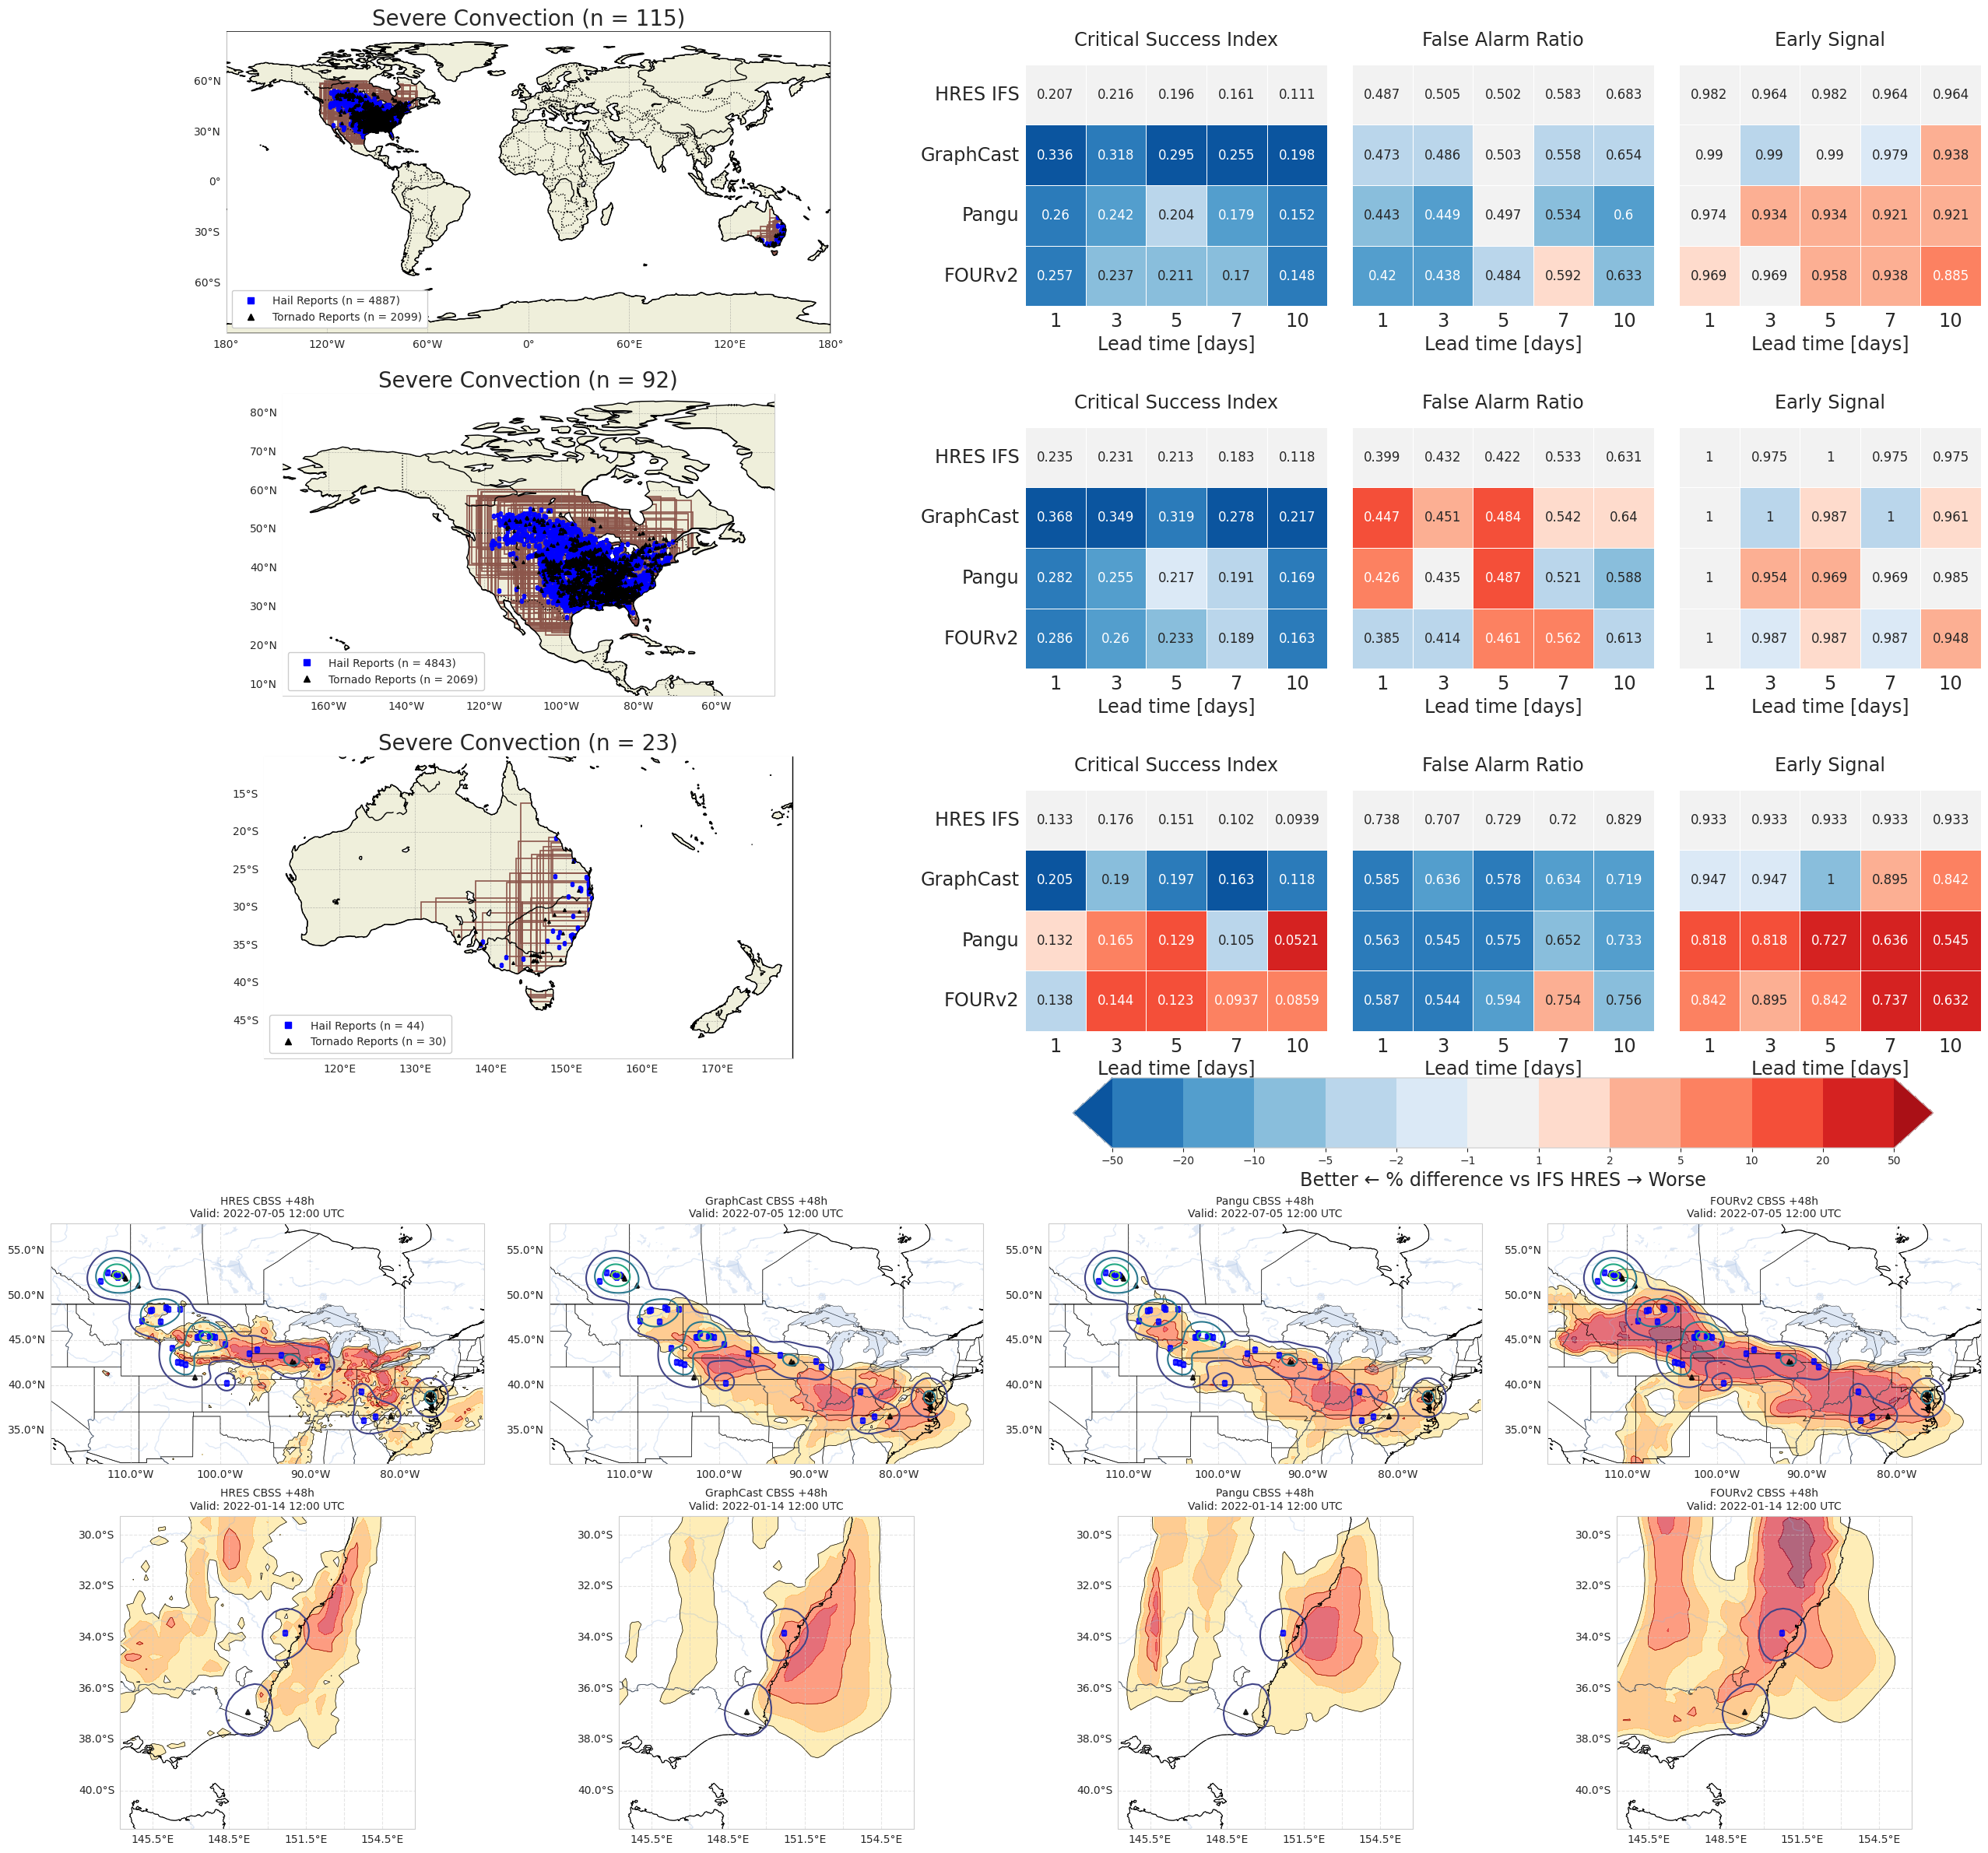

In [13]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

n_rows = 5
n_cols_top = 2  # Columns for top 3 rows
n_cols_bottom = 4  # Columns for bottom 2 rows (more Cartopy plots)
figsize = (8 * max(n_cols_top, n_cols_bottom), 6 * n_rows)
print(figsize)

# Create figure first
fig = plt.figure(figsize=figsize)

# Main GridSpec: 5 rows, use max columns for layout
# Top 3 rows will use 2 columns, bottom 2 rows will use 4 columns
gs_main = GridSpec(n_rows, 1, figure=fig, 
                #    left=0.05, right=0.95, top=0.98, bottom=0.02,
                   hspace=0.5)

# Create subplots for top 3 rows (2 columns each)
gs_top = GridSpecFromSubplotSpec(3, n_cols_top, subplot_spec=gs_main[0:3, 0],
                                  wspace=0.02, hspace=0.2,
                                  width_ratios=[1, 1])

# Create subplots for bottom 2 rows (4 columns each - all Cartopy)
gs_bottom = GridSpecFromSubplotSpec(2, n_cols_bottom, subplot_spec=gs_main[3:5, 0],
                                     wspace=0.15, hspace=0.05)

# Create all subplots - initialize as array with shape (n_rows, max_cols)
max_cols = max(n_cols_top, n_cols_bottom)
axs = np.empty((n_rows, max_cols), dtype=object)

# Top 3 rows: 2 columns (Cartopy on left, regular on right)
for i in range(3):
    # Left column: Cartopy
    ax_cartopy = fig.add_subplot(gs_top[i, 0], projection=ccrs.PlateCarree())
    axs[i,0] = ax_cartopy

    # Right column: Regular matplotlib
    ax_regular = fig.add_subplot(gs_top[i, 1])
    axs[i,1] = ax_regular

# Bottom 2 rows: 4 columns (all Cartopy)
for i in range(2):
    for j in range(n_cols_bottom):
        ax_cartopy = fig.add_subplot(gs_bottom[i, j], projection=ccrs.PlateCarree())
        axs[i+3,j] = ax_cartopy


# the left hand column of figure one shows all of the cases for each event type
# plot the cases for each event type
print("plotting the cases for each event type")
plot_utils.plot_all_cases_and_obs(
    ewb_cases,
    event_type="severe_convection",
    targets=case_operators_with_targets_established,
    ax=axs[0, 0],
)
# plot the cases for north america
plot_utils.plot_all_cases_and_obs(
    ewb_cases,
    event_type="severe_convection",
    targets=case_operators_with_targets_established,
    bounding_box=na_bounding_box,
    ax=axs[1, 0],
)

# plot the cases for australia
plot_utils.plot_all_cases_and_obs(
    ewb_cases,
    event_type="severe_convection",
    targets=case_operators_with_targets_established,
    bounding_box=au_bounding_box,
    ax=axs[2, 0],
)


severe_settings = {}
severe_settings["subplot_titles"] = severe_display_str
severe_settings["metric_str"] = severe_metric_str
severe_settings["lead_time_days"] = lead_time_days
severe_settings["model_order"] = ["HRES IFS", "GraphCast", "Pangu", "FOURv2"]

# second column of figure 2 shows the scorecard
plot_utils.plot_heatmap(
    global_rel_severe_error,
    global_severe_error,
    severe_settings,
    ax=axs[0, 1],
)

plot_utils.plot_heatmap(
    na_rel_severe_error,
    na_severe_error,
    severe_settings,
    ax=axs[1, 1],
)

plot_utils.plot_heatmap(
    au_rel_severe_error,
    au_severe_error,
    severe_settings,
    ax=axs[2, 1],
    show_colorbar=True,
)


# in the 4th row, plot the cbss and pph for all the models
my_id = 318
my_case = ewb_cases.select_cases("case_id_number", my_id).cases[0]
my_lsr = get_lsr_from_case_op(my_case, case_operators_with_targets_established)

cbss_hres, pph_hres = hres_graphics[my_id, "cbss"], hres_graphics[my_id, "pph"]
cbss_gc, pph_gc = gc_graphics[my_id, "cbss"], gc_graphics[my_id, "pph"]
cbss_pang, pph_pang = pang_graphics[my_id, "cbss"], pang_graphics[my_id, "pph"]
cbss_fourv2, pph_fourv2 = fourv2_graphics[my_id, "cbss"], fourv2_graphics[my_id, "pph"]

plot_cbss_pph_panel(cbss_hres, pph_hres, my_case, lsrs=my_lsr, ax=axs[3, 0], title="HRES", lead_time_hours=48)
plot_cbss_pph_panel(cbss_gc, pph_gc, my_case, lsrs=my_lsr, ax=axs[3, 1], title="GraphCast", lead_time_hours=48)
plot_cbss_pph_panel(cbss_pang, pph_pang, my_case, lsrs=my_lsr, ax=axs[3, 2], title="Pangu", lead_time_hours=48)
plot_cbss_pph_panel(cbss_fourv2, pph_fourv2, my_case, lsrs=my_lsr, ax=axs[3, 3], title="FOURv2", lead_time_hours=48)

# hold a spot for AIFS (just repeating PANGU for now)
# plot_cbss_pph_panel(cbss_pang, pph_pang, my_case, ax=axs[3, 3])

# # the bottom row will be australia but we are plotting NA until AUS works
# # in the 4th row, plot the cbss and pph for all the models
my_id = 269
my_case = ewb_cases.select_cases("case_id_number", my_id).cases[0]
my_lsr = get_lsr_from_case_op(my_case, case_operators_with_targets_established)

cbss_hres, pph_hres = hres_graphics[my_id, "cbss"], hres_graphics[my_id, "pph"]
cbss_gc, pph_gc = gc_graphics[my_id, "cbss"], gc_graphics[my_id, "pph"]
cbss_pang, pph_pang = pang_graphics[my_id, "cbss"], pang_graphics[my_id, "pph"]
cbss_fourv2, pph_fourv2 = fourv2_graphics[my_id, "cbss"], fourv2_graphics[my_id, "pph"]

plot_cbss_pph_panel(cbss_hres, pph_hres, my_case, lsrs=my_lsr, ax=axs[4, 0], title="HRES", lead_time_hours=48)
plot_cbss_pph_panel(cbss_gc, pph_gc, my_case, lsrs=my_lsr, ax=axs[4, 1], title="GraphCast", lead_time_hours=48)
plot_cbss_pph_panel(cbss_pang, pph_pang, my_case, lsrs=my_lsr, ax=axs[4, 2], title="Pangu", lead_time_hours=48)
plot_cbss_pph_panel(cbss_fourv2, pph_fourv2, my_case, lsrs=my_lsr, ax=axs[4, 3], title="FOURv2", lead_time_hours=48)

# # hold a spot for AIFS (just repeating PANGU for now)
# plot_cbss_pph_panel(cbss_pang, pph_pang, my_case, ax=axs[4, 3])